In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from tqdm.auto import tqdm, trange

from sklearn.model_selection import train_test_split
from sklearn.metrics import euclidean_distances

In [2]:
import sys
sys.path.append("../src/")

from iou import find_split_indices, calculate_metrics
from utils import proba2class, standardize, label_smoothing

In [3]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

σ = torch.sigmoid

In [4]:
mps_is_ok = torch.backends.mps.is_built() and torch.backends.mps.is_available()
device = torch.device('mps' if mps_is_ok else 'cpu')
print(device)

mps


In [5]:
# device = torch.device("mps")
# device = torch.device("cpu")

# Dataset

In [6]:
filename = "../data/synthetic-latest.csv"
df = pd.read_csv(
    filename,
    # nrows=int(2**14)  # debug
)

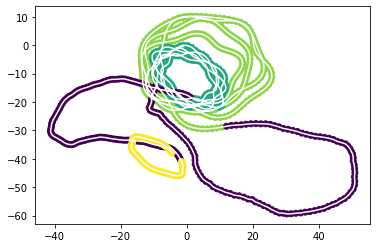

In [7]:
df_draw = df[:1_000]
plt.plot(df_draw.x, df_draw.y, "w")
plt.scatter(df_draw.x, df_draw.y, c=df_draw.period)

In [8]:
class Dataset2D(Dataset):
    
    def __init__(
        self,
        df,
        window_size=256,
        window_step=128,
        train=False
    ):
        
        self.df = df.copy()
        self.window_size = window_size
        self.window_step = window_step
        self.train = train
        
        self.indices = list(range(
            0,
            len(self.df) + 1 - self.window_size,
            self.window_step
        ))
        
    def create_sample(self, df, α=1.1):

        n = len(df)
        xyz = ["x", "y", "z"]
                
        image = euclidean_distances(df[xyz])
        image /= 100
        
        counts = df.period.value_counts()
        counts = (counts * 10 / counts.index > α) & (counts.index > 0)
        
        mask = np.zeros((n, n))
        for p in df.period.unique():
            if p == 0:
                continue
            if not counts[p]:
                continue
            m = (df.period == p).astype(float)
            m = np.tile(m, (len(m), 1))
            m = m * m.T
            mask = mask + m
            
        return image, mask
                        
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        
        i1 = self.indices[idx]
        i2 = i1 + self.window_size
        
        df_slice = self.df[i1: i2]
        
        if self.train and (np.random.rand() > 0.5):
            df_slice = df_slice[::-1]
        
        x, y = self.create_sample(df_slice)
        
        x = torch.from_numpy(x).float().unsqueeze(0)
        y = torch.from_numpy(y).float().unsqueeze(0)
        
        return x, y

In [9]:
i_train = len(df) * 8 // 10
WINDOW_SIZE = 512
WINDOW_STEP = WINDOW_SIZE // 2
dataset_train = Dataset2D(
    df[:i_train],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_STEP,
    train=True
)

dataset_test = Dataset2D(
    df[i_train:],
    window_size=WINDOW_SIZE,
    window_step=WINDOW_STEP
)

In [10]:
len(dataset_train)

474

In [11]:
x, y = dataset_train[2]

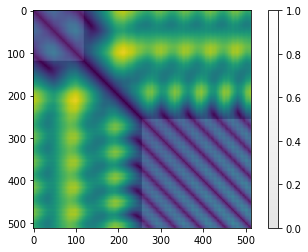

In [12]:
plt.imshow(x[0], interpolation="none")
plt.imshow(y[0], alpha=0.1, cmap="Greys_r")
plt.colorbar()

In [13]:
batch_size = 16  # len(dataset_train) // 100
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Model

In [14]:
from UNet import UNet

In [15]:
model = UNet(1, 1, hidden_channels=4)
model.eval;

In [16]:
summary(model, (1, WINDOW_SIZE, WINDOW_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 512, 512]              36
       BatchNorm2d-2          [-1, 4, 512, 512]               8
              ReLU-3          [-1, 4, 512, 512]               0
            Conv2d-4          [-1, 4, 512, 512]             144
       BatchNorm2d-5          [-1, 4, 512, 512]               8
              ReLU-6          [-1, 4, 512, 512]               0
        DoubleConv-7          [-1, 4, 512, 512]               0
         MaxPool2d-8          [-1, 4, 256, 256]               0
            Conv2d-9          [-1, 8, 256, 256]             288
      BatchNorm2d-10          [-1, 8, 256, 256]              16
             ReLU-11          [-1, 8, 256, 256]               0
           Conv2d-12          [-1, 8, 256, 256]             576
      BatchNorm2d-13          [-1, 8, 256, 256]              16
             ReLU-14          [-1, 8, 2

In [17]:
x = torch.rand(batch_size, 1, 512, 512).to(device)
model = model.to(device);

In [18]:
%%timeit
y = model(x)

61 ms ± 1.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
class DiceLoss(nn.Module):
    def __init__(self, logit=True):
        super(DiceLoss, self).__init__()
        self.logit = logit

    def forward(self, inputs, targets, smooth=1):

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        if self.logit:
            inputs = σ(inputs)
        
        intersection = (inputs * targets).sum()                            
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
    
    
class ComboLoss(nn.Module):
    def __init__(self, α=0., bce_weight=0.5):
        super(ComboLoss, self).__init__()
        self.dice = DiceLoss(logit=True)
        self.bce = nn.BCEWithLogitsLoss()
        self.α = α
        self.bce_weight = bce_weight
        self.dice_weight = 1 - bce_weight
        
    def forward(self, inputs, targets, ϵ=1):
        loss_dice = self.dice(inputs, targets)
        
        inputs = label_smoothing(targets, self.α)
        loss_bce = self.bce(inputs.view(-1), targets.view(-1)) 
        
        assert not torch.isnan(loss_dice)
        assert not torch.isnan(loss_bce)
        
        loss = self.bce_weight * loss_bce + self.dice_weight * loss_dice
        return loss

In [20]:
calculate_loss = ComboLoss(α=0.1, bce_weight=0.5)

In [21]:
model = UNet(1, 1, hidden_channels=4)
# device = torch.device("mps")
# device = torch.device("cpu")
model = model.to(device)

In [22]:
x, y = dataset_test[10]
x = x.to(device)
y = y.to(device)

In [23]:
y_pred = model(x.unsqueeze(0))

In [24]:
calculate_loss = nn.BCEWithLogitsLoss()

In [25]:
calculate_loss(y_pred, y.unsqueeze(0))

/Users/andrey/Work/bin/miniforge3/envs/torch-nightly/lib/python3.8/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor(0.7801, device='mps:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [26]:
def accuracy(pred, true):
    
    pred = pred.cpu()
    true = true.cpu()
        
    with torch.no_grad():
        pred = σ(pred) > 0.5
        
    score = torch.mean(((pred > 0.5) == (true > 0.5)).float())    
    
    return score.item()

# Train

In [27]:
def train_model(model, dataloader):
    
    loss_sum = 0
    score_sum = 0
    
    model.train()

    for X, Y in tqdm(dataloader):
        
        X = X.to(device)
        Y = Y.to(device)  
        
        optimizer.zero_grad()
        
        Y_pred = model.forward(X)
        
        assert not torch.isnan(Y_pred).any()

        loss = calculate_loss(Y_pred, Y)
        
        assert not np.isnan(loss.item())
            
        loss.backward()
        
        optimizer.step()

        score = accuracy(Y_pred, Y)
        
        loss_sum += loss.item()
        score_sum += score
        
    loss = loss_sum / len(dataloader)
    score = score_sum / len(dataloader)
        
    return loss, score

In [28]:
def test_model(model, dataloader):
    
    loss_sum = 0
    score_sum = 0
    
    metrics_all = []
    n_diffs = []
    
    with torch.no_grad():

        model.eval()
        
        for X, y_true in tqdm(dataloader):
            
            X = X.to(device)
            y_true = y_true.to(device)  
            y_pred = model(X)
            
            loss = calculate_loss(y_pred, y_true)
            
            score = accuracy(y_pred, y_true)
            
            loss_sum += loss.item()
            score_sum += score
                
    loss = loss_sum / len(dataloader)
    score = score_sum / len(dataloader)
        
    return loss, score

In [29]:
def train_epoch(model, optimizer):
    
    objectives = {}
    
    # Train
    
    loss, score = train_model(
        model,
        train_dataloader
    )
        
    objectives["loss_train"] = loss
    objectives["score_train"] = score
    
    # Test

    loss, score = test_model(
        model,
        test_dataloader
    )
    objectives["loss_test"] = loss
    objectives["score_test"] = score

    return objectives

# Main

In [30]:
# device = torch.device("cpu")
# device = torch.device("mps")

In [31]:
model = UNet(1, 1, hidden_channels=4)
model = model.to(device)

rows_progress = []
score_test_best = 0.

In [32]:
# calculate_loss = DiceLoss()
# calculate_loss = nn.BCEWithLogitsLoss()

calculate_loss = ComboLoss(α=0.1)

In [33]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-2
)

In [34]:
# pred, true = train_model(model, train_dataloader)

In [35]:
filename_model_save = "../models/unet-latest.st"

with trange(5) as t:
    for epoch in t:
        
        objectives = train_epoch(model, optimizer)
            
        rows_progress.append(objectives)
        
        score_test = objectives["score_test"]
        if score_test > score_test_best:
            score_test_best = score_test
            torch.save(model.state_dict(), filename_model_save)

        t.set_postfix(
            train=objectives["score_train"],
            test=score_test,
            best=score_test_best
        )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [36]:
df_progress = pd.DataFrame(rows_progress)

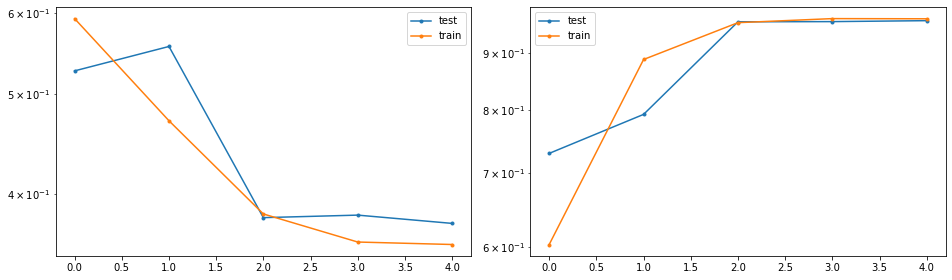

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(0.3))

for i, key in enumerate(["loss", "score"]):

    ax = axes[i]
    plt.sca(ax)

    for t in "test", "train":
        plt.plot(df_progress[f"{key}_{t}"], ".-", label=t)

    plt.legend()
    plt.yscale("log")

plt.tight_layout()

# Best

In [38]:
# model.load_state_dict(torch.load(filename_model_save))
# model.eval();

In [39]:
model = torch.jit.load('../models/unet-latest.pt')
model = model.to(device)
model.eval();

In [40]:
len(dataset_test)

117

In [41]:
x, y = dataset_test[108]
x = x.to(device)
y = y.to(device)

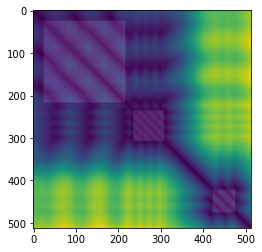

In [42]:
plt.imshow(x[0].cpu())
plt.imshow(y[0].cpu(), alpha=0.1, cmap="Greys_r")

In [43]:
with torch.no_grad():
    y_pred = model(x.unsqueeze(0))
    
output = σ(y_pred.squeeze()).cpu()

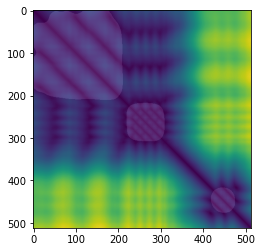

In [44]:
plt.imshow(x[0].cpu())
plt.imshow(output.cpu() > 0.5, alpha=0.1, cmap="Greys_r")

In [45]:
A = (output + output.T) / 2

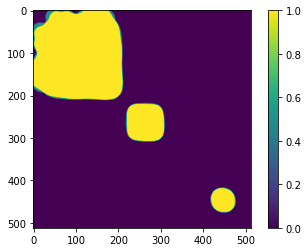

In [46]:
plt.imshow(A, vmin=0, vmax=1)
plt.colorbar()

In [47]:
def create_diag(size, n=0): 
    x = np.ones(size)
    A = np.zeros((size, size))
    for i in range(-n, n+1):
        if i == 0:
            a = np.diag(x, i)
        elif i < 0:
            a = np.diag(x[:i], i)
        else:
            a = np.diag(x[i:], i)
        A = A + a
        
    A = A / A.sum(axis=0, keepdims=True)
    
    return A


def predict_1d(pred_2d):
    M = create_diag(len(pred_2d), 4)
    pred = (pred_2d * M).sum(axis=0)
    return pred

In [48]:
pred = predict_1d(A)

In [49]:
true = predict_1d(y[0].cpu())

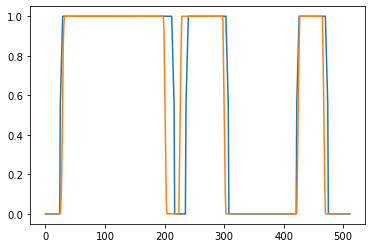

In [50]:
plt.plot(true)
plt.plot(pred)
# plt.plot(A.mean(0) > 0.05)

# Metrics

In [51]:
loss, score = test_model(
    model,
    test_dataloader
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [52]:
score

0.9811288490891457

In [53]:
scores_1d = []
scores_2d = []

for x, y in tqdm(dataset_test):
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        pred = model(x.unsqueeze(0)).squeeze()
    true = y.cpu().squeeze()
    
    scores_2d.append(accuracy(pred, true))    
        
    pred = predict_1d(pred.cpu())
    true = predict_1d(y.cpu().squeeze())
        
    scores_1d.append(accuracy(pred, true))

  0%|          | 0/117 [00:00<?, ?it/s]

In [54]:
np.mean(scores_1d)

0.9406383547008547

In [55]:
np.mean(scores_2d)

0.9811417017227564

In [56]:
def calculate_metrics(pred, true):
        
    pairs_pred = find_split_indices(pred)
    pairs_true = find_split_indices(true)
    
    n_pred = len(pairs_pred)
    n_true = len(pairs_true)

    rows = []
    
    row_template = {
        "ref": False,
        "iou": None,
        "offset": None,
        "onset": None,
        "intersection": None,
        "union": None,
    }

    for pair_pred in pairs_pred:

        i1, i2 = pair_pred
        
        row = row_template.copy()
        
        intersection = -1

        for pair_true in pairs_true:

            j1, j2 = pair_true
            
            intersection = min(i2, j2) - max(i1, j1)
            
            if intersection > 0:
                break
                
        if intersection < 0:
            continue
            rows.append(row_template)
            
        union = max(i2, j2) - min(j1, i1)
        
        row["ref"] = True
        row["intersection"] = intersection
        row["union"] = union

        if intersection * union == 0:
            iou = 0
        else:
            iou = intersection / union      

        row["iou"] = iou

        onset = i1 - j1
        offset = i2 - j2

        row["onset"] = onset
        row["offset"] = offset

        rows.append(row)

    df = pd.DataFrame(rows)
    if not len(df):
        return None, None

    columns_metrics = ["iou", "offset", "onset"]

    metrics = {
        "n_diff": n_pred - n_true,
        
        "iou_mean": df["iou"].mean(),
        "iou_std": df["iou"].std(),

        "offset_mean": df["offset"].mean(),
        "offset_std": df["offset"].std(),
        
        "onset_mean": df["onset"].mean(),
        "onset_std": df["onset"].std()
    }
    
    return metrics, df

In [57]:
df_metrics = []

for x, y in tqdm(dataset_train):
    x = x.to(device)
    y = y.to(device)
    
    with torch.no_grad():
        pred = σ(model(x.unsqueeze(0))).squeeze()
    pred = predict_1d(pred.cpu())
    true = predict_1d(y.cpu().squeeze())
    
    _, row = calculate_metrics(
        (pred > 0.5).int(),
        (true > 0.5).int(),
    )
    
    if (row["iou"] < 0).any():
        break
    
    # accuracy(
    
    df_metrics.append(row)
    
    # break
    
df_metrics = pd.concat(df_metrics)

  0%|          | 0/474 [00:00<?, ?it/s]

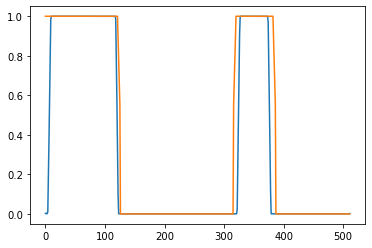

In [58]:
plt.plot(pred)
plt.plot(true)

In [59]:
df_metrics.dropna(inplace=True)

In [60]:
df_metrics.describe().round(2)

,iou,offset,onset,intersection,union
count,868.00,868.00,868.00,868.00,868.00
mean,0.88,-4.72,6.55,142.20,156.99
std,0.10,7.34,9.99,83.39,84.58
min,0.00,-36.00,-41.00,0.00,27.00
25%,0.85,-9.00,3.75,80.00,93.00
50%,0.90,-5.50,6.00,120.00,135.00
75%,0.94,-1.00,10.00,187.00,201.00
max,1.00,41.00,214.00,422.00,434.00


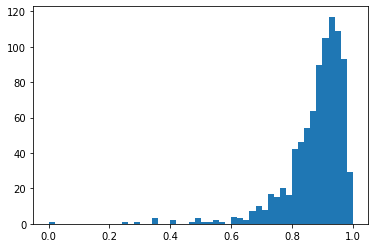

In [61]:
plt.hist(df_metrics.iou, bins=50);

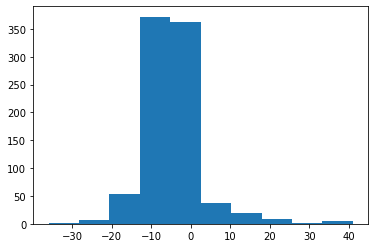

In [62]:
plt.hist(df_metrics.offset);

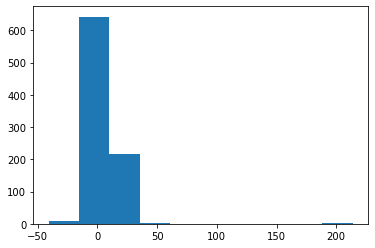

In [63]:
plt.hist(df_metrics.onset);

(-53.75, 226.75, -39.85, 44.85)

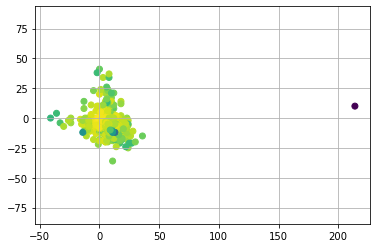

In [64]:
plt.scatter(
    df_metrics.onset,
    df_metrics.offset,
    c=df_metrics.iou
)

plt.grid()
plt.axis("equal")

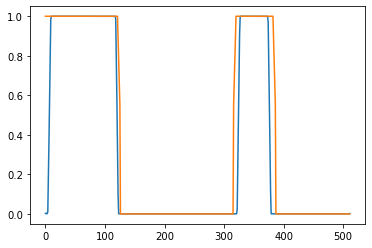

In [65]:
plt.plot(pred)
plt.plot(true)